<a href="https://colab.research.google.com/github/afifaniks/TomatoLeafDiseaseDetection/blob/master/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp 'drive/My Drive/Leaf Disease/Data_3.zip' .

In [ ]:
!unzip Data_3.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data_3/Train/Tomato_Late_Blight/bd4f09bd-ee85-4ab1-bce0-8cde3fdd7f1b___GHLB_PS Leaf 23.7 Day 13.jpg  
  inflating: Data_3/Train/Tomato_Late_Blight/bd5a4716-1cf0-46d3-a905-320e4d84d34a___RS_Late.B 6199.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd5b09dc-ca07-455b-9ff4-e02a5c7e8a42___RS_Late.B 6202.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd10f32e-3a27-4a58-9def-62555e99b223___RS_Late.B 6768.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/bd9341f4-34d9-4acb-9aa0-5dbff08f8ba6___GHLB_PS Leaf 23 Day 9.jpg  
  inflating: Data_3/Train/Tomato_Late_Blight/be2cc67b-7311-47a4-bcf7-bf62bf429533___GHLB2 Leaf 9008.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be5c294b-38cc-44b8-b404-ab7d899cb717___GHLB2 Leaf 161.1.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be9f181f-5692-4811-9678-69dbe94d6ecc___RS_Late.B 4838.JPG  
  inflating: Data_3/Train/Tomato_Late_Blight/be22c9d7-82af-4062-89c3-24cc59d461dd___GHLB 

# Importing Modules

In [ ]:
!pip install keras-unet
!pip install extra_keras_metrics

In [34]:
%tensorflow_version 1.15
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
from keras.preprocessing import image
import numpy as np
from keras_unet.metrics import iou, iou_thresholded, dice_coef
import extra_keras_metrics as ekm
from keras.utils import plot_model
import json

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Data Preparation

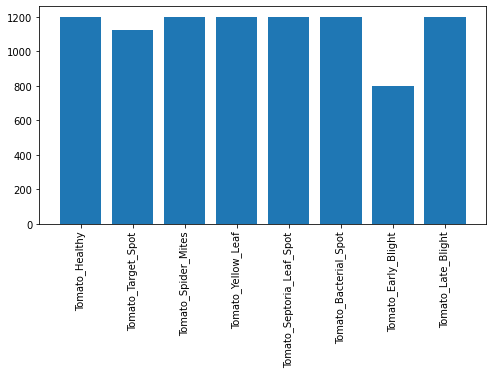

In [ ]:
data_folder = 'Data_3/Train'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

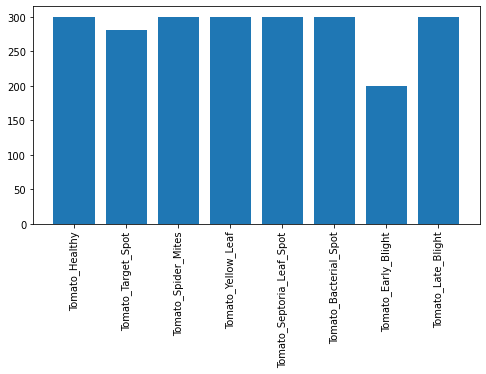

In [ ]:
data_folder = 'Data_3/Test'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
image = plt.imread('Data_3/Train/Tomato_Bacterial_Spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG')
image.shape

(256, 256, 3)

In [ ]:
# Image preprocessing
img_height = image.shape[0]
img_width = image.shape[1]

train_data_dir = 'Data_3/Train'
test_data_dir = 'Data_3/Test'

epochs = 50
batch_size = 20
batch_dim = -1

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
    batch_dim = 1
else:
    input_shape = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 9124 images belonging to 8 classes.
Found 2280 images belonging to 8 classes.


In [ ]:
train_size = len(train_generator.labels)
test_size = len(test_generator.labels)

# Model Preparation

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(Dropout(0.2))

model.add(Dense(8))
model.add(Activation(activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
______________________________________

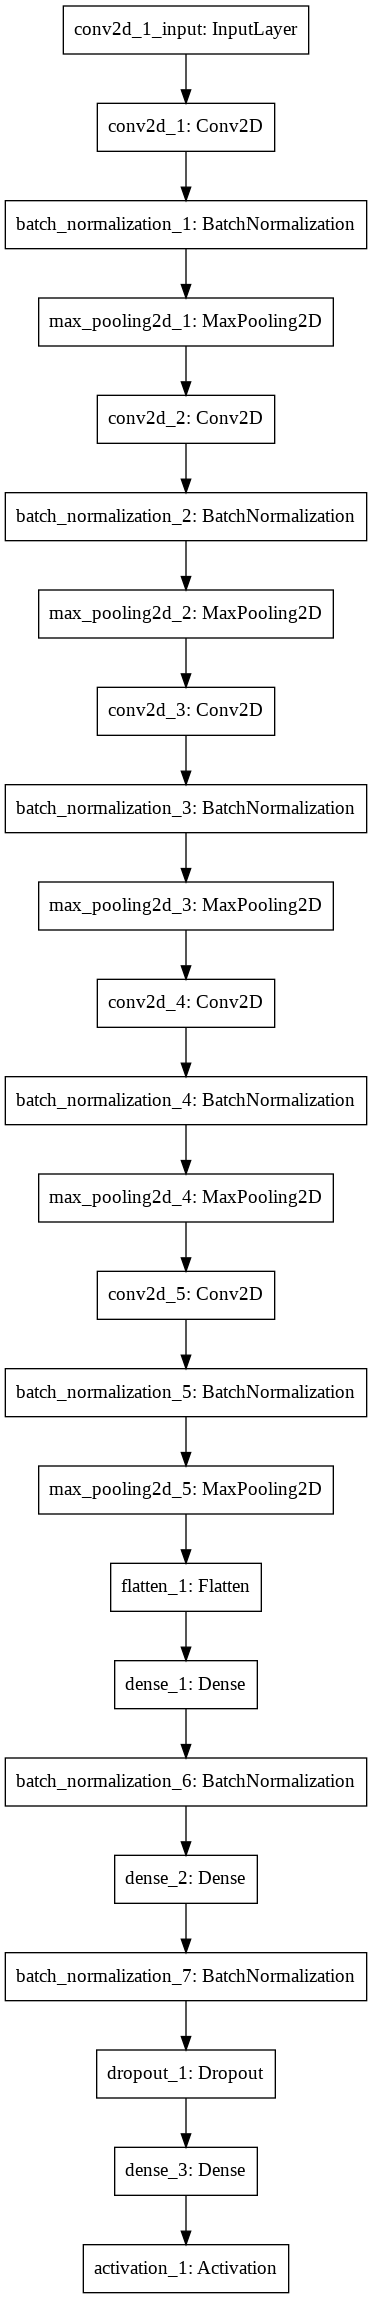

In [35]:
plot_model(model, to_file='model.png')

In [36]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('plants.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
# metrics=["accuracy", iou, iou_thresholded, dice_coef, ekm.precision, ekm.recall]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
results = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=np.ceil(train_size/batch_size), validation_data=test_generator, validation_steps=np.ceil(test_size/batch_size), callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



Epoch 1/50
457/457 [==============================] - 158s 346ms/step - loss: 0.7943 - accuracy: 0.7284 - iou: 0.4908 - iou_thresholded: 0.5909 - dice_coef: 0.6412 - precision: 0.7262 - recall: 0.5539 - val_loss: 1.9139 - val_accuracy: 0.3947 - val_iou: 0.2642 - val_iou_thresholded: 0.2616 - val_dice_coef: 0.4003 - val_precision: 0.7553 - val_recall: 0.6243

Epoch 00001: val_loss improved from inf to 1.91390, saving model to plants.h5
Epoch 2/50
457/457 [==============================] - 151s 329ms/step - loss: 0.4810 - accuracy: 0.8325 - iou: 0.6310 - iou_thresholded: 0.7311 - dice_coef: 0.7649 - precision: 0.7631 - recall: 0.6479 - val_loss: 0.4025 - val_accuracy: 0.7228 - val_iou: 0.5478 - val_iou_thresholded: 0.6032 - val_dice_coef: 0.6962 - val_precision: 0.7

# Observations

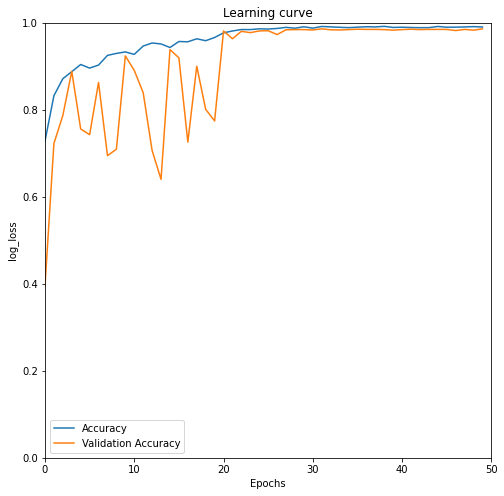

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['accuracy'], label="Accuracy")
plt.plot(results.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

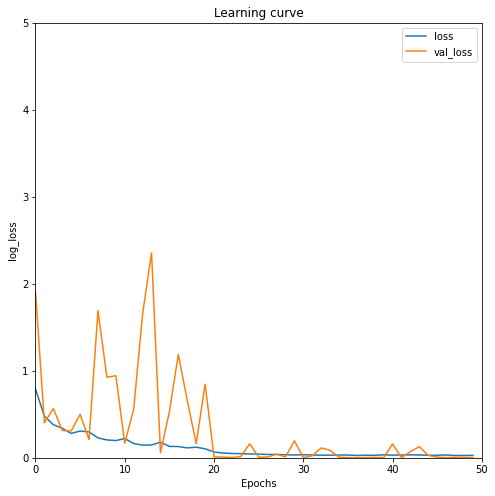

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.xlim(0, 50)
plt.ylim(0, 5)
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

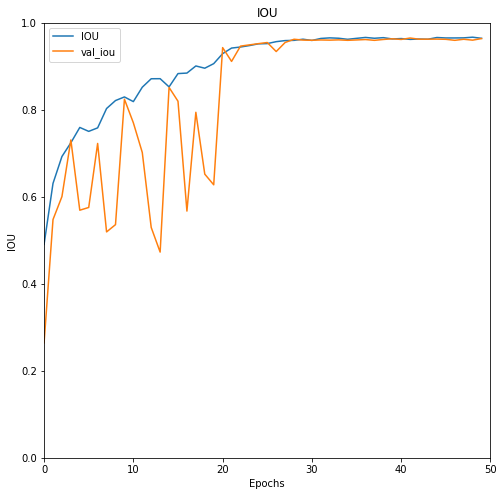

In [31]:
plt.figure(figsize=(8, 8))
plt.title("IOU")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['iou'], label="IOU")
plt.plot(results.history['val_iou'], label="val_iou")
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.legend();

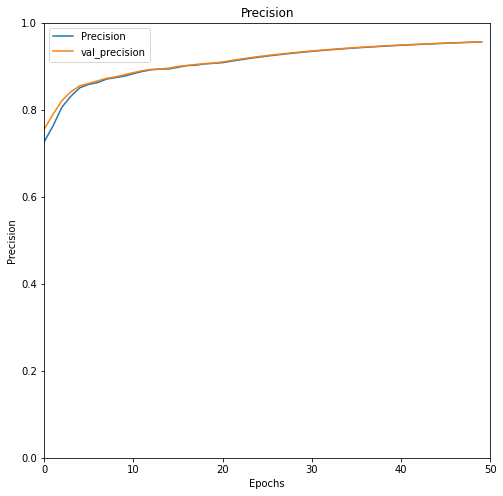

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Precision")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['precision'], label="Precision")
plt.plot(results.history['val_precision'], label="val_precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend();

# Download History

In [26]:
model_history = results.history

In [29]:
with open("history.json", "w") as f:
    json.dump(str(model_history), f)
files.download("history.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Good Job Anik! Trivial! Yet, nicely put!") #SNP